In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import csv

from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

import xgboost as xgb

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

import scipy.stats as sps

import os
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [2]:
#idx = dataset[dataset.Date == '4/1/72'].index[0]
#dataset = dataset.loc[idx:,:].reset_index(drop=True)
#dataset.head()

In [3]:
reader = csv.reader(open('Variable Dictionary.csv', 'r'))
variable_dict = {rows[0]:rows[1] for rows in reader}

In [65]:
# dataset = pd.read_csv('macrodata.csv')
# load data that includes firm credit data
credit_dataset = pd.read_csv('Macro with Stationary Credit Data.csv')
credit_dataset = credit_dataset.iloc[1:].dropna()
credit_dataset.drop('Unnamed: 0', axis=1, inplace=True)
display(credit_dataset.head())
print(credit_dataset.shape)

# load data that does not have firm credit data
macro_dataset = pd.read_csv('Macro with Stationary Bank Data.csv')
macro_dataset = macro_dataset.iloc[1:].dropna()
macro_dataset.drop('Unnamed: 0', axis=1, inplace=True)
idx1 = macro_dataset[macro_dataset.Date == '4/1/72'].index[0]
idx2 = macro_dataset[macro_dataset.Date == '12/1/17'].index[0]
macro_dataset = macro_dataset.loc[idx1:idx2,:].reset_index(drop=True)
display(macro_dataset.head())
print(macro_dataset.shape)

,Date,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,...,LOANINV,INVEST.1,USGSEC,OTHSEC,LOANS,BUSLOANS.1,REALLN.1,CONSUMER,top bottom,top middle
1,4/1/72,Normal,4451.639,4031.6,30.489,467248.274,38442.08588,42.4207,43.4172,41.0308,...,-1.4061,1.2255,0.2986,0.9268,0.2645,1.5409,0.0729,0.9422,0.000000,0.000000
2,5/1/72,Normal,4470.496,4048.4,30.642,470125.768,38949.24015,42.3956,43.3071,40.8263,...,-2.2244,-0.7870,-1.3821,0.5950,-0.2119,1.4601,-0.0482,1.0533,-1.341169,-0.392263
3,6/1/72,Normal,4482.841,4060.7,30.741,472176.951,39203.33584,42.5178,43.4734,40.8959,...,0.5140,-0.3615,-0.8109,0.4495,0.0885,1.0752,-0.3040,0.8448,-0.772088,-0.225819
4,7/1/72,Normal,4510.100,4087.1,30.967,469244.877,39412.83515,42.5004,43.7142,41.1344,...,-0.8856,-0.6773,-0.9782,0.3009,-0.5698,0.9145,0.4908,1.1644,-0.489011,-0.143025
5,8/1/72,Normal,4551.913,4128.0,31.134,480493.380,39788.27450,43.0644,44.2268,41.6305,...,0.3646,0.6642,0.0648,0.5993,-0.9769,1.3266,0.0848,1.2830,0.078274,0.149705


(550, 130)


,Date,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,...,DTCTHFNM,INVEST,LOANINV,INVEST.1,USGSEC,OTHSEC,LOANS,BUSLOANS.1,REALLN.1,CONSUMER
0,4/1/72,Normal,4451.639,4031.6,30.489,467248.274,38442.08588,42.4207,43.4172,41.0308,...,29440.0,152.5361,-1.4061,1.2255,0.2986,0.9268,0.2645,1.5409,0.0729,0.9422
1,5/1/72,Normal,4470.496,4048.4,30.642,470125.768,38949.24015,42.3956,43.3071,40.8263,...,29823.0,151.7491,-2.2244,-0.7870,-1.3821,0.5950,-0.2119,1.4601,-0.0482,1.0533
2,6/1/72,Normal,4482.841,4060.7,30.741,472176.951,39203.33584,42.5178,43.4734,40.8959,...,30273.0,151.3876,0.5140,-0.3615,-0.8109,0.4495,0.0885,1.0752,-0.3040,0.8448
3,7/1/72,Normal,4510.100,4087.1,30.967,469244.877,39412.83515,42.5004,43.7142,41.1344,...,30582.0,150.7103,-0.8856,-0.6773,-0.9782,0.3009,-0.5698,0.9145,0.4908,1.1644
4,8/1/72,Normal,4551.913,4128.0,31.134,480493.380,39788.27450,43.0644,44.2268,41.6305,...,30936.0,151.3745,0.3646,0.6642,0.0648,0.5993,-0.9769,1.3266,0.0848,1.2830


(549, 128)


In [66]:
# create lagged variables
for col in credit_dataset.drop(['Date', 'Regime'], axis=1):
    for n in [1,2,3,6,9,12,18,24]:
        credit_dataset['{} {}M lag'.format(col, n)] = credit_dataset[col].shift(n).ffill().values
        
for col in macro_dataset.drop(['Date', 'Regime'], axis=1):
    for n in [1,2,3,6,9,12,18,24]:       
        macro_dataset['{} {}M lag'.format(col, n)] = macro_dataset[col].shift(n).ffill().values
    
display(credit_dataset.head())
display(macro_dataset.head())

,Date,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,...,top bottom 18M lag,top bottom 24M lag,top middle 1M lag,top middle 2M lag,top middle 3M lag,top middle 6M lag,top middle 9M lag,top middle 12M lag,top middle 18M lag,top middle 24M lag
1,4/1/72,Normal,4451.639,4031.6,30.489,467248.274,38442.08588,42.4207,43.4172,41.0308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5/1/72,Normal,4470.496,4048.4,30.642,470125.768,38949.24015,42.3956,43.3071,40.8263,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6/1/72,Normal,4482.841,4060.7,30.741,472176.951,39203.33584,42.5178,43.4734,40.8959,...,NaN,NaN,-0.392263,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,7/1/72,Normal,4510.100,4087.1,30.967,469244.877,39412.83515,42.5004,43.7142,41.1344,...,NaN,NaN,-0.225819,-0.392263,0.000000,NaN,NaN,NaN,NaN,NaN
5,8/1/72,Normal,4551.913,4128.0,31.134,480493.380,39788.27450,43.0644,44.2268,41.6305,...,NaN,NaN,-0.143025,-0.225819,-0.392263,NaN,NaN,NaN,NaN,NaN


,Date,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,...,REALLN.1 18M lag,REALLN.1 24M lag,CONSUMER 1M lag,CONSUMER 2M lag,CONSUMER 3M lag,CONSUMER 6M lag,CONSUMER 9M lag,CONSUMER 12M lag,CONSUMER 18M lag,CONSUMER 24M lag
0,4/1/72,Normal,4451.639,4031.6,30.489,467248.274,38442.08588,42.4207,43.4172,41.0308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5/1/72,Normal,4470.496,4048.4,30.642,470125.768,38949.24015,42.3956,43.3071,40.8263,...,NaN,NaN,0.9422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6/1/72,Normal,4482.841,4060.7,30.741,472176.951,39203.33584,42.5178,43.4734,40.8959,...,NaN,NaN,1.0533,0.9422,NaN,NaN,NaN,NaN,NaN,NaN
3,7/1/72,Normal,4510.100,4087.1,30.967,469244.877,39412.83515,42.5004,43.7142,41.1344,...,NaN,NaN,0.8448,1.0533,0.9422,NaN,NaN,NaN,NaN,NaN
4,8/1/72,Normal,4551.913,4128.0,31.134,480493.380,39788.27450,43.0644,44.2268,41.6305,...,NaN,NaN,1.1644,0.8448,1.0533,NaN,NaN,NaN,NaN,NaN


In [67]:
macro_dataset.tail()

,Date,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,...,REALLN.1 18M lag,REALLN.1 24M lag,CONSUMER 1M lag,CONSUMER 2M lag,CONSUMER 3M lag,CONSUMER 6M lag,CONSUMER 9M lag,CONSUMER 12M lag,CONSUMER 18M lag,CONSUMER 24M lag
544,8/1/17,Normal,15918.081,13208.7,114.209,1456569.0,477345.0,103.1956,101.1781,100.1078,...,9.0885,1.4626,6.7176,1.6695,3.8887,3.7814,4.7111,8.0463,4.8846,7.3801
545,9/1/17,Normal,15941.890,13229.5,114.732,1466160.0,486157.0,103.1760,101.4742,100.3459,...,0.6603,2.2091,5.6530,6.7176,1.6695,2.9145,5.3750,3.6095,10.7039,7.9422
546,10/1/17,Normal,15978.509,13260.6,115.041,1472607.0,488866.0,104.7647,102.3544,101.2806,...,-11.5046,0.2198,7.1265,5.6530,6.7176,3.0642,4.4504,6.1759,7.9829,7.9052
547,11/1/17,Normal,15997.387,13306.1,115.576,1480434.0,492633.0,105.2943,102.3929,101.1668,...,10.2590,15.5238,14.7455,7.1265,5.6530,3.8887,3.7814,4.7111,8.0236,5.8419
548,12/1/17,Normal,16033.336,13338.5,115.706,1483917.0,492643.0,105.7698,102.7945,101.4940,...,-5.5807,-9.2759,13.1357,14.7455,7.1265,1.6695,2.9145,5.3750,13.5710,7.3717


In [68]:
credit_dataset['Label'] = credit_dataset['Regime'].apply(lambda regime: 1. if regime == 'Normal' else 0.)
credit_labels_one_quarter = credit_dataset['Label'].shift(-3).ffill().values # for 1 quarter ahead prediction
credit_dataset['Date'] = pd.to_datetime(credit_dataset['Date'])

macro_dataset['Label'] = macro_dataset['Regime'].apply(lambda regime: 1. if regime == 'Normal' else 0.)
macro_labels_one_quarter = macro_dataset['Label'].shift(-3).ffill().values # for 1 quarter ahead prediction
macro_dataset['Date'] = pd.to_datetime(macro_dataset['Date'])

In [69]:
seed = 7
scoring = 'roc_auc'
# Time Series Split
credit_idx = credit_dataset[credit_dataset.Date == '12/1/00'].index[0]
credit_training_features = credit_dataset.loc[:credit_idx,:].drop(['Regime','Date','Label'], axis=1)
credit_validation_features = credit_dataset.loc[credit_idx+1:, :].drop(['Regime','Date','Label'], axis=1)
credit_training_targets = credit_labels_one_quarter[:credit_idx]
credit_validation_targets = credit_labels_one_quarter[credit_idx:]

macro_idx = macro_dataset[macro_dataset.Date == '12/1/00'].index[0]
macro_training_features = macro_dataset.loc[:macro_idx,:].drop(['Regime','Date','Label'], axis=1)
macro_validation_features = macro_dataset.loc[macro_idx+1:, :].drop(['Regime','Date','Label'], axis=1)
macro_training_targets = macro_labels_one_quarter[:macro_idx+1]
macro_validation_targets = macro_labels_one_quarter[macro_idx+1:]

In [70]:
print(len(credit_training_features), len(credit_training_targets), len(credit_validation_features), len(credit_validation_targets))
print(len(macro_training_features), len(macro_training_targets), len(macro_validation_features), len(macro_validation_targets))

345 345 205 205
345 345 204 204


In [198]:
def credit_objective(params):
    params = {
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'gamma': "{:.3f}".format(params['gamma']),
        'reg_alpha': '{:.3f}'.format(params['reg_alpha']),
        'reg_lambda': '{:.3f}'.format(params['reg_lambda']),
        'n_estimator': int(params['n_estimators']),
        'subsample': '{:.3f}'.format(params['subsample'])
        # 'max_depth': int(params['max_depth'])
    }
    
    clf = xgb.XGBClassifier(
        booster='gbtree',
        max_depth=1,
        learning_rate=0.1,
        n_jobs=4,
        objective='binary:logistic',
        **params
    )
    
    score = model_selection.cross_val_score(clf, credit_training_features, credit_training_targets, scoring=scoring, cv=model_selection.TimeSeriesSplit()).mean()
    # print("AUC {:.3f} params {}".format(score, params))
    return score

def macro_objective(params):
    params = {
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'gamma': "{:.3f}".format(params['gamma']),
        'reg_alpha': '{:.3f}'.format(params['reg_alpha']),
        'reg_lambda': '{:.3f}'.format(params['reg_lambda']),
        'n_estimator': int(params['n_estimators']),
        'subsample': '{:.3f}'.format(params['subsample'])
        #'max_depth': int(params['max_depth'])
    }
    
    clf = xgb.XGBClassifier(
        booster='gbtree',
        max_depth=1,
        learning_rate=0.1,
        n_jobs=4,
        objective='binary:logistic',
        **params
    )
    
    score = model_selection.cross_val_score(clf, macro_training_features, macro_training_targets, scoring=scoring, cv=model_selection.TimeSeriesSplit()).mean()
    # print("AUC {:.3f} params {}".format(score, params))
    return score

In [199]:
space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),  
   
    'reg_alpha'       : hp.uniform('alpha', 1e-6, 1e-4),
    'reg_lambda'      : hp.uniform('lambda', 1e-6, 1e-4),
    
    # 'learning_rate'    : hp.loguniform('learning_rate', -6.9, -2.3),
    'n_estimators': hp.choice('n_estimators', np.arange(25, 1000, 25, dtype=int)),
    # 'max_depth': hp.choice('max_depth', np.arange(1, 5, dtype=int)),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05)
   }

In [213]:
best_params = []

for i in range(1):
    credit_best = fmin(fn=credit_objective,
                space=space,
                algo=tpe.suggest,
                max_evals=10)

    macro_best = fmin(fn=macro_objective,
                space=space,
                algo=tpe.suggest,
                max_evals=10)
    
    best_params.append([credit_best, macro_best])

In [214]:
params_list = ['alpha', 'colsample_bytree', 'gamma', 'lambda', 'n_estimators', 'subsample']
credit_params = []
macro_params = []

for i in range(len(best_params)):
    credit_params.append([best_params[i][0][s] for s in params_list])
    macro_params.append([best_params[i][1][s] for s in params_list])
    
credit_params = pd.DataFrame(credit_params, columns=params_list)
macro_params = pd.DataFrame(macro_params, columns=params_list)

print(credit_params.describe())
print(macro_params.describe())

          alpha  colsample_bytree     gamma   lambda  n_estimators  subsample
count  1.000000          1.000000  1.000000  1.00000           1.0        1.0
mean   0.000093          0.477325  0.404654  0.00002          34.0        0.6
std         NaN               NaN       NaN      NaN           NaN        NaN
min    0.000093          0.477325  0.404654  0.00002          34.0        0.6
25%    0.000093          0.477325  0.404654  0.00002          34.0        0.6
50%    0.000093          0.477325  0.404654  0.00002          34.0        0.6
75%    0.000093          0.477325  0.404654  0.00002          34.0        0.6
max    0.000093          0.477325  0.404654  0.00002          34.0        0.6
          alpha  colsample_bytree     gamma    lambda  n_estimators  subsample
count  1.000000           1.00000  1.000000  1.000000           1.0        1.0
mean   0.000021           0.92891  0.119397  0.000074          16.0        0.5
std         NaN               NaN       NaN       NaN        

In [215]:
print(credit_best)
print()
print(macro_best)

{'alpha': 9.332576951430311e-05, 'colsample_bytree': 0.4773247770001278, 'gamma': 0.40465416409127786, 'lambda': 2.0156533402111307e-05, 'n_estimators': 34, 'subsample': 0.6000000000000001}

{'alpha': 2.0968173087363717e-05, 'colsample_bytree': 0.9289100378016275, 'gamma': 0.11939700643074241, 'lambda': 7.388680835868324e-05, 'n_estimators': 16, 'subsample': 0.5}


In [216]:
credit_model = xgb.XGBClassifier(booster='gbtree', 
                                 max_depth=1, 
                                 learning_rate=0.1, 
                                 n_jobs=4, 
                                 objective='binary:logistic', 
                                 **credit_best)
credit_model.fit(credit_training_features, credit_training_targets)

macro_model = xgb.XGBClassifier(booster='gbtree', 
                                max_depth=1, 
                                learning_rate=0.1, 
                                n_jobs=4, 
                                objective='binary:logistic', 
                                **macro_best)
macro_model.fit(macro_training_features, macro_training_targets)

XGBClassifier(alpha=2.0968173087363717e-05, base_score=0.5, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=0.9289100378016275,
       gamma=0.11939700643074241, lambda=7.388680835868324e-05,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=16, n_jobs=4,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

In [217]:
credit_predictions = credit_model.predict(credit_validation_features)
credit_prob_predictions = credit_model.predict_proba(credit_validation_features)
print('ROC Score: %f' % (roc_auc_score(credit_validation_targets, credit_prob_predictions[:,1])))
print('Confusion Matrix: ')
display(pd.DataFrame(confusion_matrix(credit_validation_targets, credit_predictions), index=['Actual Contraction', 'Actual Normal'], columns=['Predicted Contraction', 'Predicted Normal']))
print(classification_report(credit_validation_targets, credit_predictions))

macro_predictions = macro_model.predict(macro_validation_features)
macro_prob_predictions = macro_model.predict_proba(macro_validation_features)
print('ROC Score: %f' % (roc_auc_score(macro_validation_targets, macro_prob_predictions[:,1])))
print('Confusion Matrix: ')
display(pd.DataFrame(confusion_matrix(macro_validation_targets, macro_predictions), index=['Actual Contraction', 'Actual Normal'], columns=['Predicted Contraction', 'Predicted Normal']))
print(classification_report(macro_validation_targets, macro_predictions))

ROC Score: 0.691889
Confusion Matrix: 


,Predicted Contraction,Predicted Normal
Actual Contraction,0,25
Actual Normal,0,180


             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        25
        1.0       0.88      1.00      0.94       180

avg / total       0.77      0.88      0.82       205

ROC Score: 0.815978
Confusion Matrix: 


,Predicted Contraction,Predicted Normal
Actual Contraction,0,25
Actual Normal,0,179


             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        25
        1.0       0.88      1.00      0.93       179

avg / total       0.77      0.88      0.82       204



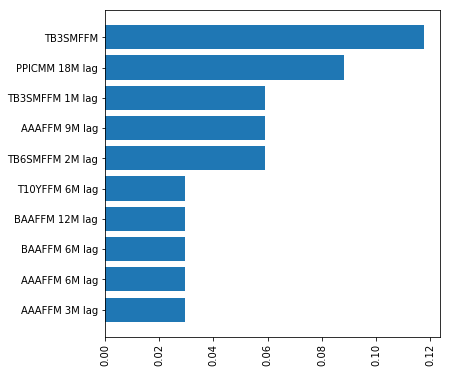

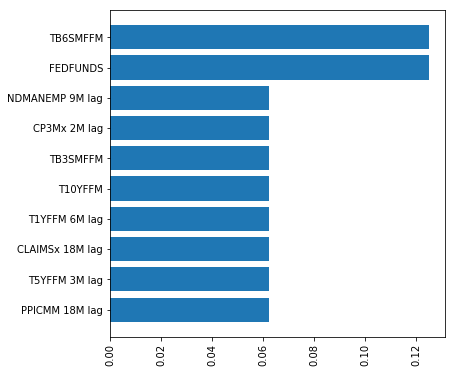

In [218]:
# find feature importances
credit_headers = credit_dataset.drop(['Regime','Label', 'Date'], axis=1).columns.values.tolist()
credit_model_importances = pd.DataFrame(credit_model.feature_importances_, index = credit_headers, columns = ['Relative Importance'])
_ = credit_model_importances.sort_values(by = ['Relative Importance'], ascending = False, inplace=True)
credit_model_importances = credit_model_importances[credit_model_importances['Relative Importance']>0].iloc[:10] # take 10 most important features

macro_headers = macro_dataset.drop(['Regime','Label', 'Date'], axis=1).columns.values.tolist()
macro_model_importances = pd.DataFrame(macro_model.feature_importances_, index = macro_headers, columns = ['Relative Importance'])
_ = macro_model_importances.sort_values(by = ['Relative Importance'], ascending = False, inplace=True)
macro_model_importances = macro_model_importances[macro_model_importances['Relative Importance']>0].iloc[:10] # take 10 most important features

# display importances in bar-chart
fig = plt.figure(figsize=(6,6))
plt.xticks(rotation='90')
plt.barh(y=np.arange(len(credit_model_importances)), 
         width=credit_model_importances['Relative Importance'], 
         align='center', 
         tick_label=credit_model_importances.index)
plt.gca().invert_yaxis()
plt.show()

fig = plt.figure(figsize=(6,6))
plt.xticks(rotation='90')
plt.barh(y=np.arange(len(macro_model_importances)), 
         width=macro_model_importances['Relative Importance'], 
         align='center', 
         tick_label=macro_model_importances.index)
plt.gca().invert_yaxis()
plt.show()

In [219]:
variable_dict['AAA']

"Moody's Seasoned AAA Corporate Bond Yield"

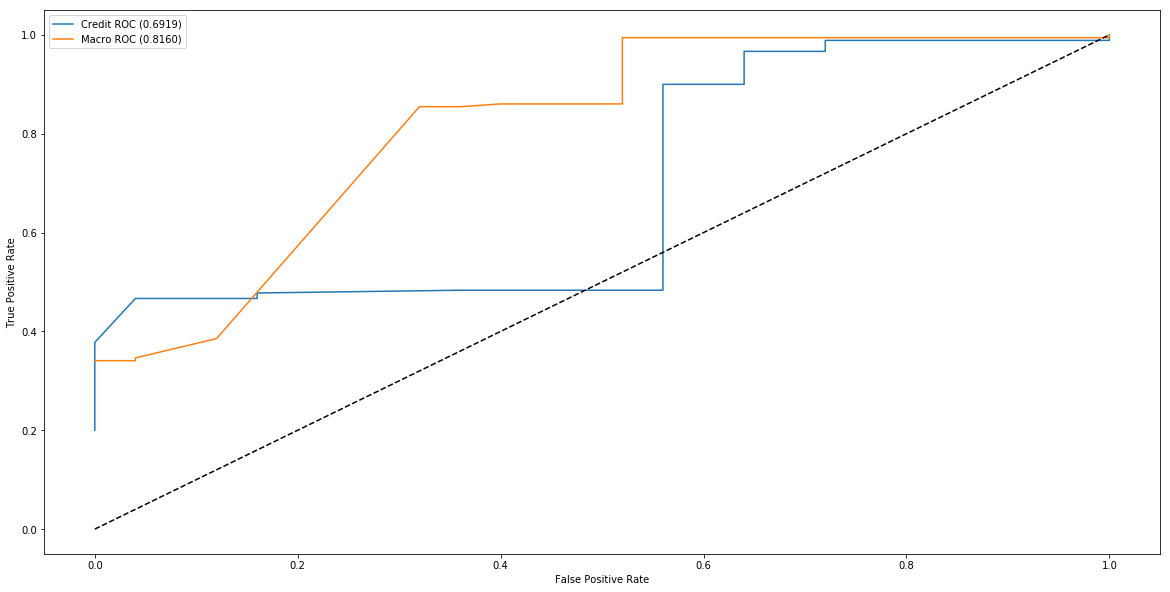

In [220]:
# plotting ROC curves of the models
roc = []

credit_oos = credit_model.predict_proba(credit_validation_features)
credit_fpr, credit_tpr, _ = roc_curve(credit_validation_targets, credit_oos[:,1])
roc.append([credit_fpr, credit_tpr])
credit_roc_score = roc_auc_score(credit_validation_targets, credit_oos[:,1])

macro_oos = macro_model.predict_proba(macro_validation_features)
macro_fpr, macro_tpr, _ = roc_curve(macro_validation_targets, macro_oos[:,1])
roc.append([macro_fpr, macro_tpr])
macro_roc_score = roc_auc_score(macro_validation_targets, macro_oos[:,1])

plt.figure(figsize=(20,10))
for i in range(len(roc)):
    plt.plot(roc[i][0], roc[i][1])
plt.plot([0, 1], [0, 1], color='k', ls='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(labels=['Credit ROC ({:.4f})'.format(credit_roc_score), 'Macro ROC ({:.4f})'.format(macro_roc_score)])
# put auc score in legend
plt.show()

In [221]:
credit_prob_predictions = credit_model.predict_proba(credit_training_features)
credit_prob_predictions = np.append(credit_prob_predictions, credit_model.predict_proba(credit_validation_features), axis=0)

macro_prob_predictions = macro_model.predict_proba(macro_training_features)
macro_prob_predictions = np.append(macro_prob_predictions, macro_model.predict_proba(macro_validation_features), axis=0)

In [222]:
rec_spans = []
rec_spans.append([dt.datetime(1973,11,1), dt.datetime(1975,3,1)])
rec_spans.append([dt.datetime(1980,1,1), dt.datetime(1980,6,1)])
rec_spans.append([dt.datetime(1981,7,1), dt.datetime(1982,10,1)])
rec_spans.append([dt.datetime(1990,7,1), dt.datetime(1991,2,1)])
rec_spans.append([dt.datetime(2001,3,1), dt.datetime(2001,10,1)])
rec_spans.append([dt.datetime(2007,12,1), dt.datetime(2009,5,1)])

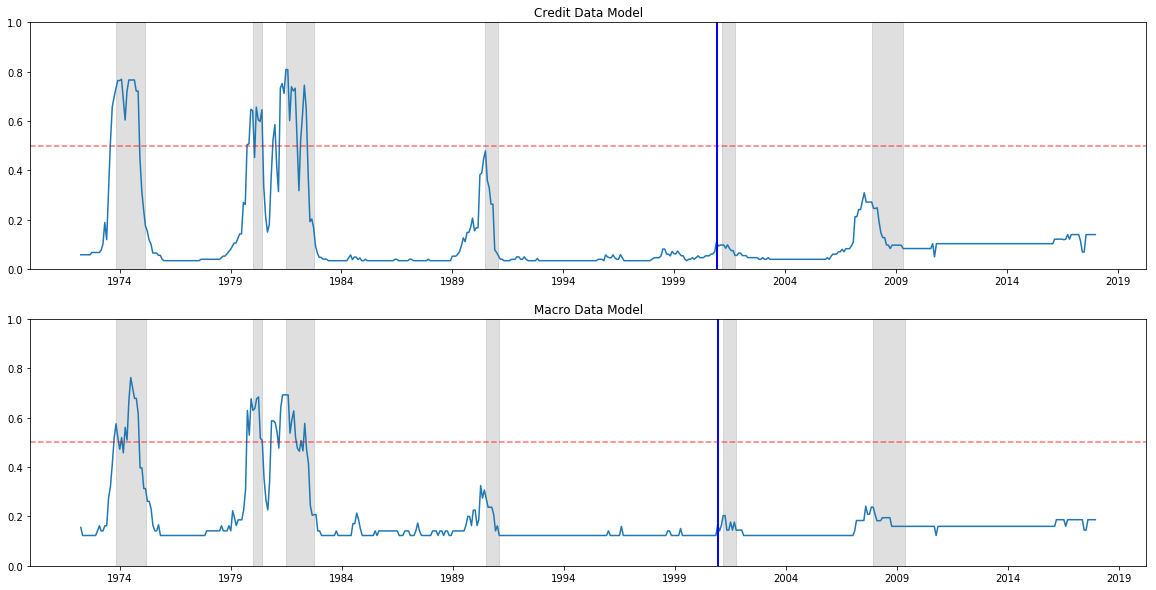

In [223]:
# probs = pd.DataFrame(prob_predictions[:,0], index=)
fig, axes = plt.subplots(2, 1, figsize=(20,10))
ax1 = axes[0]
ax2 = axes[1]

ax1.plot(credit_dataset['Date'], credit_prob_predictions[:,0])
ax1.set_title('Credit Data Model')
#ax1.axhline(y=0.13, ls='dashed', alpha=0.5)
#ax1.axhline(y=0.19, ls='dashed', alpha=0.5)

ax2.plot(macro_dataset['Date'], macro_prob_predictions[:,0])
ax2.set_title('Macro Data Model')
#ax2.axhline(y=0.24, ls='dashed', alpha=0.5)
#ax2.axhline(y=0.3, ls='dashed', alpha=0.5)

for ax in axes:
    ax.set_ylim(0,1)
    for rec_start, rec_end in rec_spans:
        ax.axvspan(rec_start, rec_end, alpha=0.25, color='gray', edgecolor=None)
        ax.axhline(y=0.5, alpha=0.1, color='r', ls='dashed')
        ax.axvline(x=dt.datetime(2000,12,1), color='b', alpha=0.75)
        
plt.show()

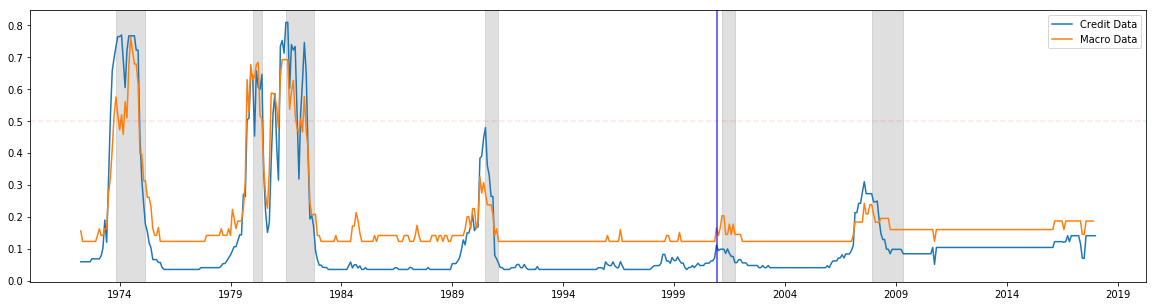

In [224]:
plt.figure(figsize=(20,5))
plt.plot(credit_dataset['Date'], credit_prob_predictions[:,0])
plt.plot(macro_dataset['Date'], macro_prob_predictions[:,0])
for rec_start, rec_end in rec_spans:
    plt.axvspan(rec_start, rec_end, alpha=0.25, color='gray', edgecolor=None)
plt.axhline(y=0.5, alpha=0.1, color='r', ls='dashed')
plt.axvline(x=dt.datetime(2000,12,1), color='b', alpha=0.75)
plt.legend(labels=['Credit Data', 'Macro Data'])
plt.show()

In [225]:
credit_booster = credit_model.get_booster()
credit_booster.dump_model('credit_model.txt', with_stats=True)
with open('credit_model.txt', 'r') as f:
    txt_model = f.read()
print(txt_model)
print()

macro_booster = macro_model.get_booster()
macro_booster.dump_model('macro_model.txt', with_stats=True)
with open('macro_model.txt', 'r') as f:
    txt_model = f.read()
print(txt_model)
print()

booster[0]:
0:[TB3SMFFM<-1.47000003] yes=1,no=2,missing=1,gain=37.3200874,cover=49.75
	1:leaf=-0.0758620724,cover=6.25
	2:leaf=0.175280914,cover=43.5
booster[1]:
0:[TB3SMFFM<-1.38499999] yes=1,no=2,missing=1,gain=36.4307594,cover=46.9230537
	1:leaf=-0.0908976197,cover=5.74018383
	2:leaf=0.165338218,cover=41.182869
booster[2]:
0:[TB6SMFFM 2M lag<-1.74000001] yes=1,no=2,missing=2,gain=37.3997955,cover=52.1256561
	1:leaf=-0.10509906,cover=6.16496754
	2:leaf=0.144282877,cover=45.9606857
booster[3]:
0:[TB3SMFFM 1M lag<-1.50999999] yes=1,no=2,missing=2,gain=32.5050697,cover=51.0764465
	1:leaf=-0.0859460235,cover=6.40821981
	2:leaf=0.144283757,cover=44.6682281
booster[4]:
0:[FEDFUNDS<11.2700005] yes=1,no=2,missing=1,gain=31.2088737,cover=50.3872185
	1:leaf=0.130789727,cover=44.7583618
	2:leaf=-0.10520649,cover=5.62885666
booster[5]:
0:[TB6SMFFM 2M lag<-1.14999998] yes=1,no=2,missing=2,gain=24.2763805,cover=46.5710182
	1:leaf=-0.0518400855,cover=8.66601849
	2:leaf=0.128393263,cover=37.9049988


In [ ]:
spx = pd.read_csv('SP500.csv')
spx['Date'] = pd.to_datetime(spx['Date'])
spx = spx[['Date', 'Adj Close']]
spx.set_index('Date', inplace=True)
spx = spx.loc[dataset.loc[idx+1:, :]['Date']]

In [ ]:
import pandas_datareader.data as web

In [211]:
start = dt.datetime(2000, 12, 1)
end = dt.datetime(2018, 8, 1)

gdp = web.DataReader('GDP', 'fred', start, end)

gdp_growth = (gdp.shift(-1)/gdp - 1)*100
gdp_growth.bfill(inplace=True)

In [212]:
fig, axes = plt.subplots(3,1, figsize=(20,15), sharex=True)
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

ax1.plot(dataset['Date'], prob_predictions[:,0])
ax2.plot(gdp_growth.index, gdp_growth.values)
ax3.plot(spx.index, spx.values)

for ax in axes:
    ax.axvspan(dt.datetime(2001,3,1), dt.datetime(2001,10,1), alpha=0.25, color='grey')
    ax.axvspan(dt.datetime(2007,12,1), dt.datetime(2009,5,1), alpha=0.25, color='grey')

ax1.legend(labels=['Predicted probability of recession', 'Recession'])
ax2.legend(labels=['GDP Growth', 'Recession'])
ax3.legend(labels=['SP500', 'Recession'])

# plt.show()